## Post processing of the one sided diffusor case 

#### 1 General variables

In [235]:
# file path
#path = '../test_cases/RANS_kOmega-SST_2D/output/resultSteadyState'
#path = '../test_cases/RANS_kOmega-SST_2D/output/resultSteadyState1'

#path = '../test_cases/RANS_kOmega-SST_2D/output/resultTransient'
#path = '../test_cases/RANS_kOmega-SST_2D/output/resultTransient1' # cellLimited Gauss linear 1.0 relaxation p 0.5, time 0,015
#path = '../test_cases/RANS_kOmega-SST_2D/output/resultTransient2' # cellLimited Gauss linear 1.0 relaxation p 0.8, time 0.015
#path = '../test_cases/RANS_kOmega-SST_2D/output/resultTransient3' # cellLimited Gauss linear 1.0 relaxation p 0.8, time 0.015
#path = '../test_cases/RANS_kOmega-SST_2D/output/resultTransient4' # cellLimited leastSquare 1.0 relaxation p 0.4, time 0.1
#path = '../test_cases/RANS_kOmega-SST_2D/output/resultTransient5' # cellLimited leastSquare 1.0 relaxation p 0.8, time 0.055
#path = '../test_cases/RANS_kOmega-SST_2D/output/resultTransient3.1' # cellLimited Gauss linear 1.0 relaxation p 0.8, time 0.5
#path = '../test_cases/RANS_kOmega-SST_2D/output/resultTransient6' # cellLimited leastSquares 1.0 relaxation p 0.8, U 0.95 time 0.01
#path = '../test_cases/RANS_kOmega-SST_2D/output/resultTransient7' # cellLimited Gauss linear 1.0 relaxation p 0.4; U 0.9 , time 0.01
#path = '../test_cases/RANS_kOmega-SST_2D/output/resultTransient8' # cellLimited Gauss linear 1.0 relaxation p 0.4; U 0.9 , time 0.01, maxCo 0.95
#path = '../test_cases/RANS_kOmega-SST_2D/output/resultTransient9' # cellLimited Gauss linear 1.0 relaxation p 0.8; U 0.95 , time 0.01, maxCo 0.95
path = '../test_cases/RANS_kOmega-SST_2D/output/resultTransient10' # cellLimited Gauss linear 1.0 relaxation p 0.4; U 0.95 , time 0.01, maxCo 0.95, relTol p 0.001

# time to which case was solved used for the pressure difference 
last_time = 0.01

# number of iterations at which the wall shear stress is analyzed
time = 0.01


# angle of the ramp
angle = 20

# density of the airflow 
rhoL = 1.225

#### 1.1 Used Libaries

In [236]:
# loading libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 2 Functions

#### 2.1 Function to plot residuals

In [237]:
def residuals():
    # column names 
    colnames = [
        "Time", "U_solver", "Ux_initial", "Ux_final", "Ux_iters",
        "Uy_initial", "Uy_final", "Uy_iters", "U_converged",
        "k_solver", "k_initial", "k_final", "k_iters", "k_converged",
        "omega_solver", "omega_initial", "omega_final", "omega_iters", "omega_converged",
        "p_solver", "p_initial", "p_final", "p_iters", "p_converged"
    ]


    # plotting 
    plt.figure(figsize=(12, 6))
    filepath = str(path) + '/postProcessing/solverInfo/0/solverInfo.dat'
        
        # reading data
    df = pd.read_csv(filepath, sep=r'\s+', skiprows=2, names=colnames)
        
    plt.plot(df["Time"], df["Ux_initial"], label="Ux_initial")
    plt.plot(df["Time"], df["Uy_initial"], label="Uy_initial")
    plt.plot(df["Time"], df["k_initial"], label="k_initial")
    plt.plot(df["Time"], df["p_initial"], label="p_initial")
    plt.plot(df["Time"], df["omega_initial"], label="omega_initial")
        
    plt.xlabel("Time")
    plt.ylabel("Initial residuals (log)")
    plt.title(f"Initial residuals")
    plt.yscale('log')
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.xlim(0, last_time)

    # showing layout
    plt.tight_layout()
    plt.show()

#### 2.2 Function to plot and create tables of the wall shear stress along the lower wall

In [238]:
def process_file(file_path):
    data_pairs = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('#') or not line.strip():
                continue

            parts = line.strip().split()
            if len(parts) >= 9:
                x = float(parts[0])

                area = np.array([
                    float(parts[6]),
                    float(parts[7]),
                    float(parts[8])
                ])
                norm = np.linalg.norm(area)
                area_normalized = area / norm if norm != 0 else area
                
                # cross product of the ez and and area normal vektor to get a vector following the wall
                ez = np.array([0, 0, 1])
                cross_prod = np.cross(area_normalized, ez)

                shear = np.array([
                    float(parts[3]),
                    float(parts[4]),
                    float(parts[5])
                ])

                # transformation of the wss vector in the wall following COS
                scalar_product = np.dot(shear, cross_prod)

                # multiplying by density to get [Pa]
                wss = rhoL*scalar_product
                data_pairs.append((x, wss))

    # sorting
    data_pairs.sort(key=lambda pair: pair[0])
    return sorted(data_pairs, key=lambda pair: pair[0])


def plot_wss():
    plt.figure(figsize=(10, 5))
    

   
    file_path = (
        str(path) + "/postProcessing/samples/" + str(time) + "/wallShearStress_lowerWall.raw"
    )

    data_pairs = process_file(file_path)
    x_vals = [pair[0] for pair in data_pairs]
    scalar_vals = [pair[1] for pair in data_pairs]

    plt.plot(x_vals, scalar_vals)
        
    plt.title('wall shear stresses at the lower wall')
    plt.xlabel('global x value in mm ')
    plt.ylabel('wall shear stress in Pa')
    plt.xlim(0, 0.4)
    plt.ylim(-0.7, 0.5)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [239]:
def interpolate_wss_at_points(x_targets):
    results = {'x': x_targets}

    
    # file path to use the process_file function to calculate the transformed wss
    file_path = (
        str(path) + "/postProcessing/samples/" + str(time) + "/wallShearStress_lowerWall.raw"
    )

    # loading data
    data_pairs = process_file(file_path)
    x_vals = np.array([pair[0] for pair in data_pairs])
    scalar_vals = np.array([pair[1] for pair in data_pairs])

    # linear interpolation 
    interpolated = np.interp(x_targets, x_vals, scalar_vals)

    # adding to table 
    results[f'transient'] = interpolated

    # dataFrame output 
    df = pd.DataFrame(results)
    return df

#### 2.3 Function to plot the wall shear stress along the upper wall 

In [240]:
def wss_upperWall(file_path):
    data_wss_upperWall = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('#') or not line.strip():
                continue

            parts = line.strip().split()
            if len(parts) >= 9:
                x = float(parts[0])

                area = np.array([
                    float(parts[6]),
                    float(parts[7]),
                    float(parts[8])
                ])
                
                wss_x = float(parts[3])
                
                # openFoam wss in m²/s² needs multiplikation with rho to match experiment
                wss = rhoL*wss_x
                data_wss_upperWall.append((x, wss))

    # sorting
    data_wss_upperWall.sort(key=lambda pair: pair[0])
    return sorted(data_wss_upperWall, key=lambda pair: pair[0])


def plot_wss_upperWall():
    plt.figure(figsize=(10, 5))
        
    # choosing file path
    file_path = (
        str(path) + "/postProcessing/samples/" + str(time) + "/wallShearStress_upperWall.raw"
    )

    data_wss_upperWall = process_file(file_path)
    x_vals = [pair[0] for pair in data_wss_upperWall]
    scalar_vals = [pair[1] for pair in data_wss_upperWall]

    plt.plot(x_vals, scalar_vals)
        
    plt.title('wall shear stresses at the upper wall')
    plt.xlabel('global x value in mm ')
    plt.ylabel('wall shear stress in Pa')
    plt.xlim(-0.3, 2)
    #plt.ylim(-1, 0.3)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### 2.4 Function to calculate the pressure difference

In [241]:
def delta_p(file_path):
    data_pairs = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('#') or not line.strip():
                continue

            parts = line.strip().split()

            time = float(parts[0])

            # using the absolute value of p_inlet as delta_p
            delta_p = np.array(abs(float(parts[1])))

            data_pairs.append((time, delta_p))
    return data_pairs

def plot_delta_p():
    plt.figure(figsize=(10, 5))  
  
    file_path = (
        str(path) + "/postProcessing/delta_p:pInlet/0/surfaceFieldValue.dat"
    )

    data_pairs = delta_p(file_path)
    x_vals = [pair[0] for pair in data_pairs]
    scalar_vals = [pair[1] for pair in data_pairs]

    plt.plot(x_vals, scalar_vals)
        
    plt.title('Pressure difference over the diffusor')
    plt.xlabel('time')
    plt.ylabel('absolute value of the pressure in m²/s²')
    plt.xlim(0, last_time)
    #plt.ylim(-0.5, 0.5)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



## 3 Plots and tables 

#### 3.1 Plot of the residuals 

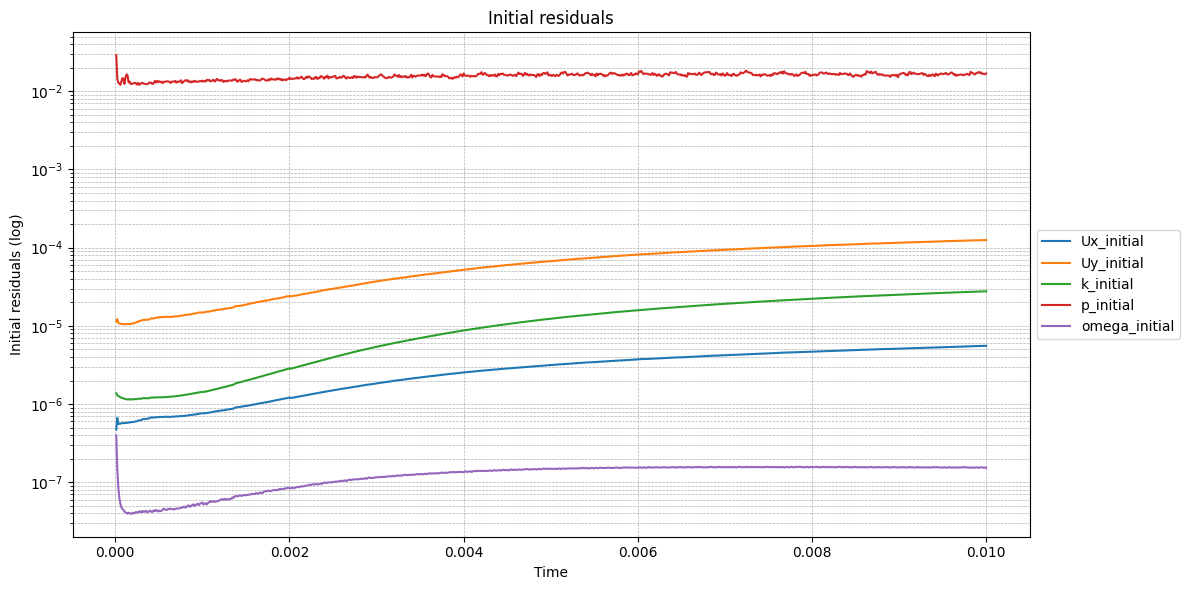

In [242]:
residuals()

#### 3.2 Plot of the wall shear stress along the lower wall 

/tmp/ipykernel_1774/705844580.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


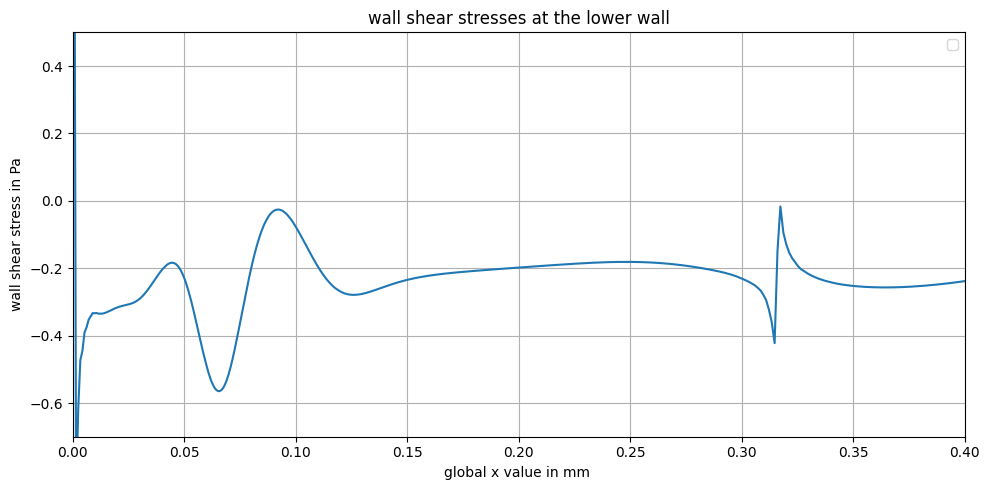

In [243]:
plot_wss()

#### 3.3 Table of the wall shear stress at the lower wall at certain points in the global COS

In [244]:
# desired x values 
x_targets = np.array([0.082, 0.122, 0.162, 0.202, 0.242, 0.282, 0.386])

# executing functions for interpolation and table 
interpolation_table = interpolate_wss_at_points(x_targets)
print(interpolation_table.to_string(index=False))

    x  transient
0.082  -0.145170
0.122  -0.274965
0.162  -0.219923
0.202  -0.197056
0.242  -0.181663
0.282  -0.199698
0.386  -0.249485


#### 3.4 Table of the wall shear stress at the lower wall at certain points in the ramp COS

In [245]:
# values of x in transformed from the global COS to the COS of the ramp
ramp_x = np.cos(np.radians(angle))*x_targets

# Interpolation ausführen und anzeigen
interpolation_table2 = interpolate_wss_at_points(ramp_x)
print(interpolation_table2.to_string(index=False))

       x  transient
0.077055  -0.291336
0.114642  -0.239440
0.152230  -0.231065
0.189818  -0.202940
0.227406  -0.185731
0.264993  -0.185468
0.362721  -0.256919


#### 3.5 Plot of the wall shear stress along the upper wall (sample doesnt exist jet)

/tmp/ipykernel_1774/2089511393.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


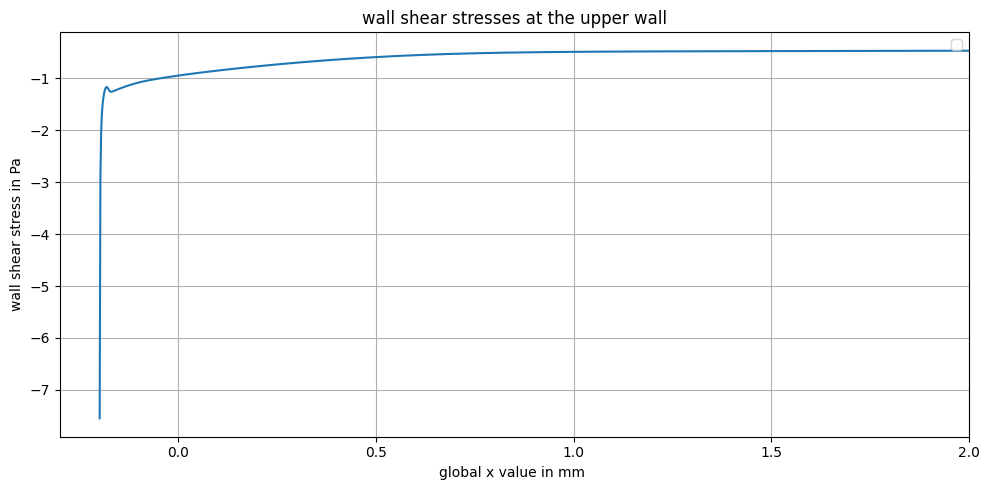

In [246]:
plot_wss_upperWall()

#### 3.6 Plot of the pressure differnce over the diffusor

/tmp/ipykernel_1774/152857264.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


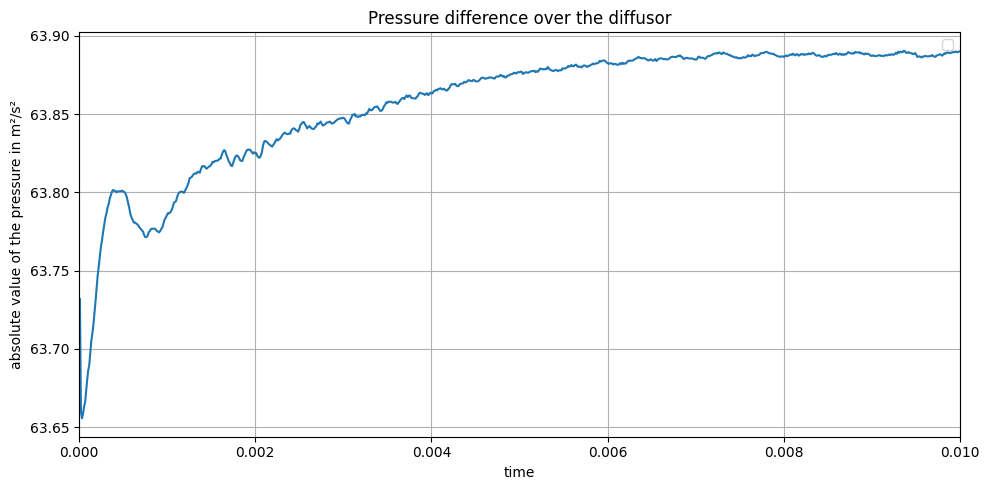

In [247]:
plot_delta_p()